## Case Study 1: Superconductor Dataset
### Prediction of Critical Temperature and Interpretation of Superconducting Material Properties
### Kristin Henderson
### May 12, 2025

The problem concerns superconductors, which are materials give little or no resistence to electrical current.

The goal is to predict new superconductor materials and the temperature at which they operate or become superconductors.

The model needs to both predict and be interpretable because the goals is to both identify new superconductors but also to learn at what temperature those materials are likely to develop superconducting properties.

The input is data based on properties of known superconductor material composition and the temperature required for superconductance.


### Import Libraries and Set Global Seed

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

# To avoid ChildProcessError (in fine tuning ElasticNet)
# patch the resource_tracker to prevent it from trying to unregister unused resources
import multiprocessing.resource_tracker
multiprocessing.resource_tracker.unregister = lambda name, rtype: None

# Set seed for reproducibility
SEED = 13 # global constant

### Import Data and View Summary Statistics

In [2]:
# Import the data
train = pd.read_csv('data/train.csv')
train.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [3]:
# Import the 2nd part of the dataset
unique_m = pd.read_csv('data/unique_m.csv')
unique_m.head()

,H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Ba0.1La1.9Cu1O4
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,Ba0.15La1.85Cu1O4
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,Ba0.3La1.7Cu1O4


In [4]:
train.shape, unique_m.shape

((21263, 82), (21263, 88))

In [5]:
train.dtypes

number_of_elements         int64
mean_atomic_mass         float64
wtd_mean_atomic_mass     float64
gmean_atomic_mass        float64
wtd_gmean_atomic_mass    float64
                          ...   
range_Valence              int64
wtd_range_Valence        float64
std_Valence              float64
wtd_std_Valence          float64
critical_temp            float64
Length: 82, dtype: object

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 82 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   number_of_elements               21263 non-null  int64  
 1   mean_atomic_mass                 21263 non-null  float64
 2   wtd_mean_atomic_mass             21263 non-null  float64
 3   gmean_atomic_mass                21263 non-null  float64
 4   wtd_gmean_atomic_mass            21263 non-null  float64
 5   entropy_atomic_mass              21263 non-null  float64
 6   wtd_entropy_atomic_mass          21263 non-null  float64
 7   range_atomic_mass                21263 non-null  float64
 8   wtd_range_atomic_mass            21263 non-null  float64
 9   std_atomic_mass                  21263 non-null  float64
 10  wtd_std_atomic_mass              21263 non-null  float64
 11  mean_fie                         21263 non-null  float64
 12  wtd_mean_fie      

In [7]:
# look at the column labels
train.columns

Index(['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass',
       'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass',
       'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass',
       'std_atomic_mass', 'wtd_std_atomic_mass', 'mean_fie', 'wtd_mean_fie',
       'gmean_fie', 'wtd_gmean_fie', 'entropy_fie', 'wtd_entropy_fie',
       'range_fie', 'wtd_range_fie', 'std_fie', 'wtd_std_fie',
       'mean_atomic_radius', 'wtd_mean_atomic_radius', 'gmean_atomic_radius',
       'wtd_gmean_atomic_radius', 'entropy_atomic_radius',
       'wtd_entropy_atomic_radius', 'range_atomic_radius',
       'wtd_range_atomic_radius', 'std_atomic_radius', 'wtd_std_atomic_radius',
       'mean_Density', 'wtd_mean_Density', 'gmean_Density',
       'wtd_gmean_Density', 'entropy_Density', 'wtd_entropy_Density',
       'range_Density', 'wtd_range_Density', 'std_Density', 'wtd_std_Density',
       'mean_ElectronAffinity', 'wtd_mean_ElectronAffinity',
       'gmean_

In [8]:
# look at the index labels
train.index

RangeIndex(start=0, stop=21263, step=1)

In [9]:
# get summary statistics
train.describe()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
count,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,...,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000
mean,4.115224,87.557631,72.988310,71.290627,58.539916,1.165608,1.063884,115.601251,33.225218,44.391893,...,3.153127,3.056536,3.055885,1.295682,1.052841,2.041010,1.483007,0.839342,0.673987,34.421219
std,1.439295,29.676497,33.490406,31.030272,36.651067,0.364930,0.401423,54.626887,26.967752,20.035430,...,1.191249,1.046257,1.174815,0.393155,0.380291,1.242345,0.978176,0.484676,0.455580,34.254362
min,1.000000,6.941000,6.423452,5.320573,1.960849,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000210
25%,3.000000,72.458076,52.143839,58.041225,35.248990,0.966676,0.775363,78.512902,16.824174,32.890369,...,2.116732,2.279705,2.091251,1.060857,0.775678,1.000000,0.921454,0.451754,0.306892,5.365000
50%,4.000000,84.922750,60.696571,66.361592,39.918385,1.199541,1.146783,122.906070,26.636008,45.123500,...,2.618182,2.615321,2.434057,1.368922,1.166532,2.000000,1.063077,0.800000,0.500000,20.000000
75%,5.000000,100.404410,86.103540,78.116681,73.113234,1.444537,1.359418,154.119320,38.356908,59.322812,...,4.026201,3.727919,3.914868,1.589027,1.330801,3.000000,1.918400,1.200000,1.020436,63.000000
max,9.000000,208.980400,208.980400,208.980400,208.980400,1.983797,1.958203,207.972460,205.589910,101.019700,...,7.000000,7.000000,7.000000,2.141963,1.949739,6.000000,6.992200,3.000000,3.000000,185.000000


In [10]:
unique_m.dtypes

H                float64
He                 int64
Li               float64
Be               float64
B                float64
                  ...   
Po                 int64
At                 int64
Rn                 int64
critical_temp    float64
material          object
Length: 88, dtype: object

In [11]:
unique_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 88 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   H              21263 non-null  float64
 1   He             21263 non-null  int64  
 2   Li             21263 non-null  float64
 3   Be             21263 non-null  float64
 4   B              21263 non-null  float64
 5   C              21263 non-null  float64
 6   N              21263 non-null  float64
 7   O              21263 non-null  float64
 8   F              21263 non-null  float64
 9   Ne             21263 non-null  int64  
 10  Na             21263 non-null  float64
 11  Mg             21263 non-null  float64
 12  Al             21263 non-null  float64
 13  Si             21263 non-null  float64
 14  P              21263 non-null  float64
 15  S              21263 non-null  float64
 16  Cl             21263 non-null  float64
 17  Ar             21263 non-null  int64  
 18  K     

In [12]:
unique_m.columns

Index(['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al',
       'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn',
       'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb',
       'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In',
       'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm',
       'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta',
       'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At',
       'Rn', 'critical_temp', 'material'],
      dtype='object')

In [13]:
unique_m.index

RangeIndex(start=0, stop=21263, step=1)

In [14]:
unique_m.describe()

,H,He,Li,Be,B,C,N,O,F,Ne,...,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp
count,21263.000000,21263.0,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.0,...,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.0,21263.0,21263.0,21263.000000
mean,0.017685,0.0,0.012125,0.034638,0.142594,0.384968,0.013284,3.009129,0.014874,0.0,...,0.034108,0.020535,0.036663,0.047954,0.042461,0.201009,0.0,0.0,0.0,34.421219
std,0.267220,0.0,0.129552,0.848541,1.044486,4.408032,0.150427,3.811649,0.132119,0.0,...,0.307888,0.717975,0.205846,0.272298,0.274365,0.655927,0.0,0.0,0.0,34.254362
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000210
25%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,5.365000
50%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,20.000000
75%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,6.800000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,63.000000
max,14.000000,0.0,3.000000,40.000000,105.000000,120.000000,12.800000,66.000000,4.000000,0.0,...,5.800000,64.000000,8.000000,7.000000,19.000000,14.000000,0.0,0.0,0.0,185.000000


### Join Numerical Features and Vector-Encoded Features

In [15]:
# Check that the common feature, `critical_temp` are equivalent in both datasets in all rows
are_equal = (train['critical_temp'] == unique_m['critical_temp']).all()
print('Critical temps match across datasets:', are_equal)

Critical temps match across datasets: True


In [16]:
# Rename `train` so I don't overwrite it when I join the datasets
train_numFeatures = train.copy()

In [17]:
# Create a new train dataset joining the datasets columnwise, dropping the duplicate column, `critical_temp`
train = pd.concat([train_numFeatures.drop(columns=['critical_temp']), unique_m], axis=1)
print(train.shape)
print(train_numFeatures.shape[1] - 1 + unique_m.shape[1]) # sanity check
train.head()

(21263, 169)
169


,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Ba0.1La1.9Cu1O4
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,Ba0.15La1.85Cu1O4
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,Ba0.3La1.7Cu1O4


### Plot the Target Variable Distribution

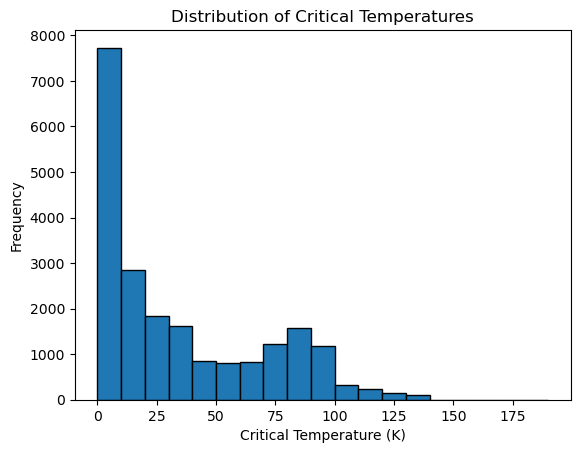

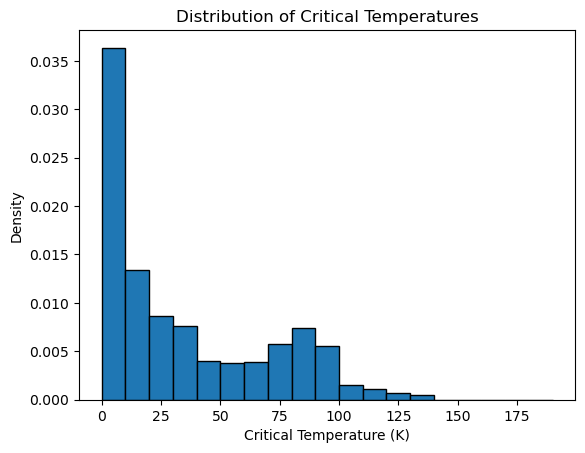

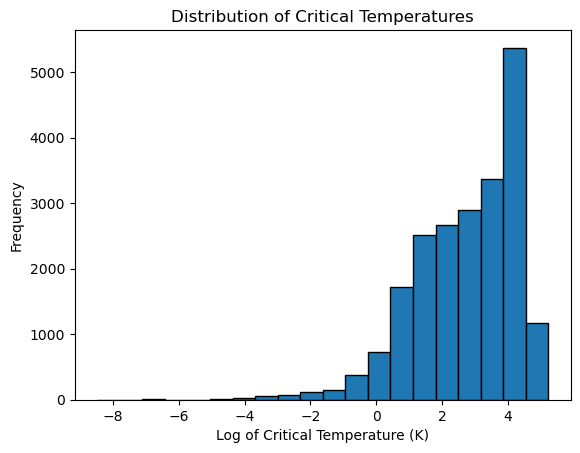

In [18]:
# Create histogram
plt.hist(train['critical_temp'], bins=np.arange(0,200,10), edgecolor='black')
plt.title('Distribution of Critical Temperatures')
plt.xlabel('Critical Temperature (K)')
plt.ylabel('Frequency')
plt.show()

# Create histogram
plt.hist(train['critical_temp'], bins=np.arange(0,200,10), density=True, edgecolor='black')
plt.title('Distribution of Critical Temperatures')
plt.xlabel('Critical Temperature (K)')
plt.ylabel('Density')
plt.show()

# Have a look with log transformation
plt.hist(np.log(train['critical_temp']), bins=20, edgecolor='black')
plt.title('Distribution of Critical Temperatures')
plt.xlabel('Log of Critical Temperature (K)')
plt.ylabel('Frequency')
plt.show()

Questions:
1. Any additional information on the data, including what each column represents
   - There is a metadata file detailing each variable.
2. Is there any missing data?
   - No
3. How will the scientists determine if the model is interpretable?
   - Will need to tell them the relative importance of each variable.

Assignment:
- Build 2 linear regression models (L1 and L2) and an optional 3rd using both.
- Provide the top 10 most important variables
- Discuss the results
- Use appropriate cross-validation

### Split the Data into X and y

In [19]:
# Create an X, y
X = train.drop(columns=['critical_temp', 'material'])
y = train['critical_temp']
print(X.shape, y.shape)

(21263, 167) (21263,)


### Check for Perfect Correlation Between Features

In [20]:
# Check for perfectly correlated features
corr_matrix = X.corr()

# tril_indices_from gets the indexes of the diagonals and lower triangle 
# Set the diagonal and lower triangle to NaN to avoid self-comparisons and duplicate comparisons
corr_matrix.values[np.tril_indices_from(corr_matrix)] = np.nan

# Find remaining pairs with perfect correlation
perfect_corrs = corr_matrix[(corr_matrix == 1.0) | (corr_matrix == -1.0)].stack()
print(perfect_corrs)

Series([], dtype: float64)


In [21]:
X.columns[:81]

Index(['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass',
       'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass',
       'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass',
       'std_atomic_mass', 'wtd_std_atomic_mass', 'mean_fie', 'wtd_mean_fie',
       'gmean_fie', 'wtd_gmean_fie', 'entropy_fie', 'wtd_entropy_fie',
       'range_fie', 'wtd_range_fie', 'std_fie', 'wtd_std_fie',
       'mean_atomic_radius', 'wtd_mean_atomic_radius', 'gmean_atomic_radius',
       'wtd_gmean_atomic_radius', 'entropy_atomic_radius',
       'wtd_entropy_atomic_radius', 'range_atomic_radius',
       'wtd_range_atomic_radius', 'std_atomic_radius', 'wtd_std_atomic_radius',
       'mean_Density', 'wtd_mean_Density', 'gmean_Density',
       'wtd_gmean_Density', 'entropy_Density', 'wtd_entropy_Density',
       'range_Density', 'wtd_range_Density', 'std_Density', 'wtd_std_Density',
       'mean_ElectronAffinity', 'wtd_mean_ElectronAffinity',
       'gmean_

### Scale the Numerical Features

In [22]:
# Scale the numerical predictors
scaler = StandardScaler()
X_scaled_num = pd.DataFrame(scaler.fit_transform(X.iloc[:, :81]), columns=X.columns[:81], index=X.index)
X_scaled_num.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,mean_Valence,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence
0,-0.080058,0.046733,-0.451651,-0.158850,-0.611819,0.044358,-0.003707,0.133725,-0.053039,0.378186,...,-0.907755,-0.752156,-0.805912,-0.711705,0.186292,0.035183,-0.837959,-0.406166,-0.838372,-0.520070
1,0.614744,0.174269,-0.432071,0.059368,-0.604180,0.777430,-0.015267,0.133725,0.108900,0.134901,...,-1.147084,-0.752156,-1.116731,-0.719454,0.664971,-0.014779,-0.033011,-0.362352,-0.426866,-0.450821
2,-0.080058,0.046733,-0.450978,-0.158850,-0.611658,0.044358,-0.218984,0.133725,0.093294,0.378186,...,-0.907755,-0.740164,-0.805912,-0.700728,0.186292,-0.062235,-0.837959,-0.376957,-0.838372,-0.503304
3,-0.080058,0.046733,-0.451314,-0.158850,-0.611739,0.044358,-0.103615,0.133725,0.020128,0.378186,...,-0.907755,-0.746160,-0.805912,-0.706224,0.186292,-0.010538,-0.837959,-0.391562,-0.838372,-0.511524
4,-0.080058,0.046733,-0.452324,-0.158850,-0.611980,0.044358,0.162775,0.133725,-0.199372,0.378186,...,-0.907755,-0.764149,-0.805912,-0.722618,0.186292,0.113627,-0.837959,-0.435376,-0.838372,-0.538178


In [23]:
# Concatenate the scaled numerical predictors with the vector encoded predictors
X_scaled = pd.concat([X_scaled_num, X.iloc[:, 81:]], axis=1)
X_scaled.iloc[:, 76:86]


,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,H,He,Li,Be,B
0,0.035183,-0.837959,-0.406166,-0.838372,-0.520070,0.0,0,0.0,0.0,0.0
1,-0.014779,-0.033011,-0.362352,-0.426866,-0.450821,0.0,0,0.0,0.0,0.0
2,-0.062235,-0.837959,-0.376957,-0.838372,-0.503304,0.0,0,0.0,0.0,0.0
3,-0.010538,-0.837959,-0.391562,-0.838372,-0.511524,0.0,0,0.0,0.0,0.0
4,0.113627,-0.837959,-0.435376,-0.838372,-0.538178,0.0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
21258,-0.366001,-0.837959,0.701200,-0.838372,-0.388706,0.0,0,0.0,0.0,0.0
21259,0.747878,-0.837959,-0.591160,-0.906487,-1.011981,0.0,0,0.0,0.0,0.0
21260,-1.583774,-0.837959,1.755341,-0.700159,-0.601416,0.0,0,0.0,0.0,0.0
21261,-1.249706,-0.837959,0.743230,-0.700159,-0.464240,0.0,0,0.0,0.0,0.0


### Plot the Feature Distributions

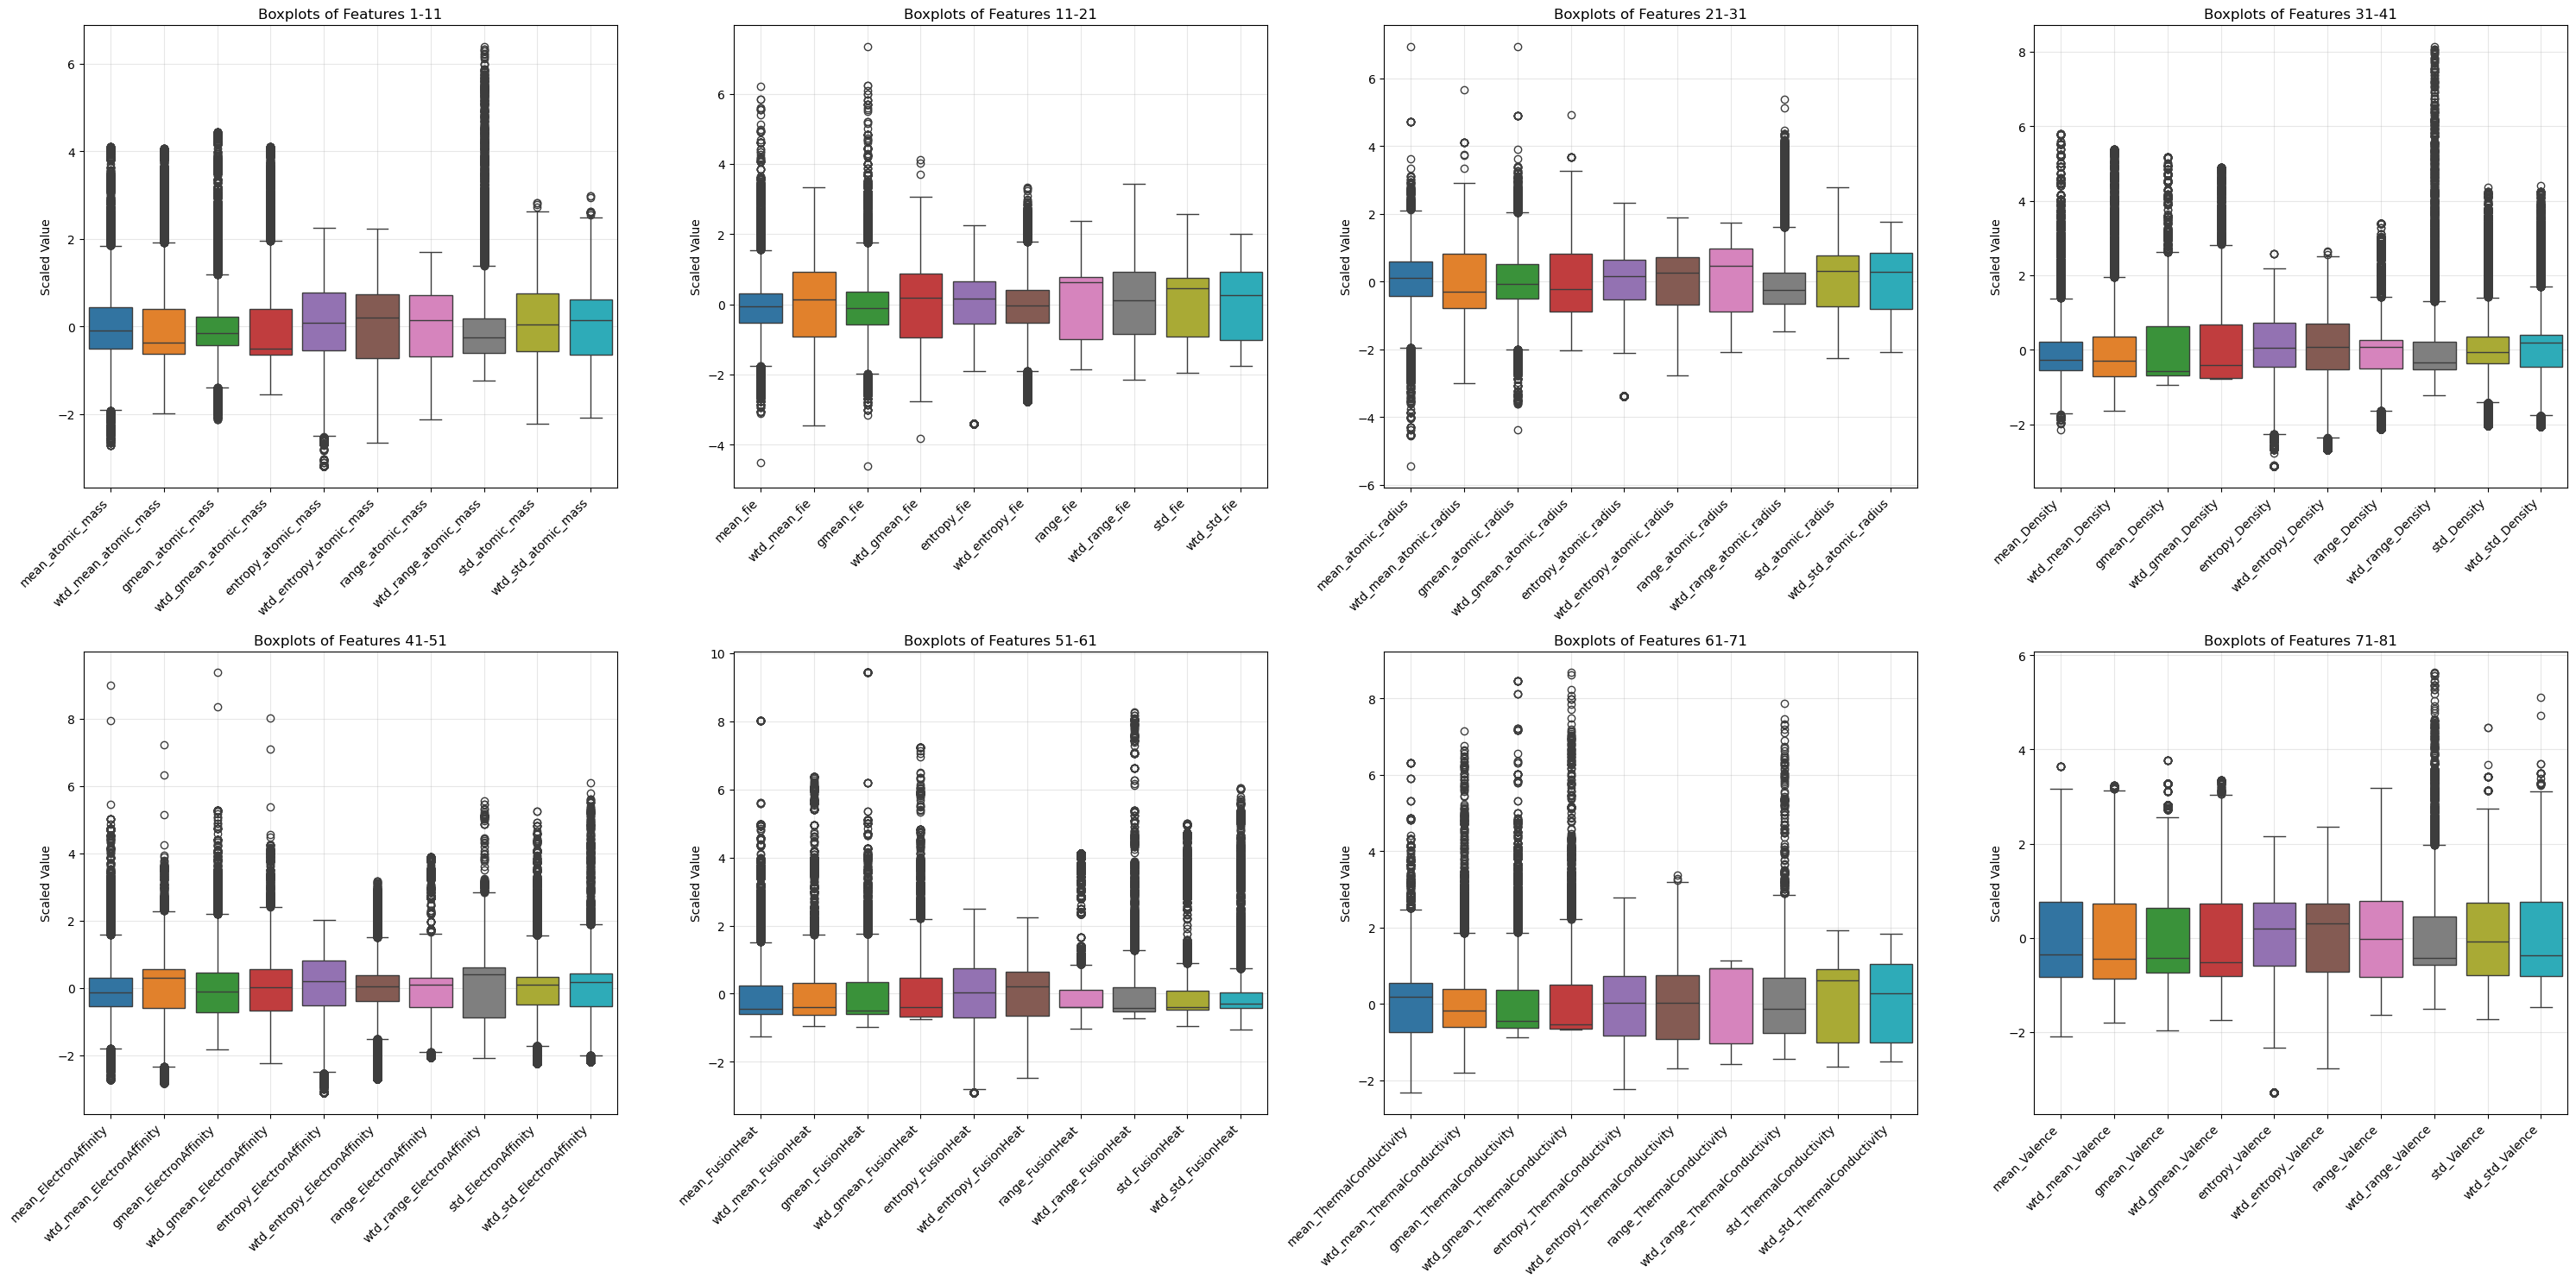

In [24]:
# Set up the figure size
plt.figure(figsize=(30, 15))

# Create box plots for each group of 10 features
for i in range(8):  # 8 groups of 10 features
    plt.subplot(2, 4, i+1)
    
    # Get the columns for this group (10 features at a time)
    start_idx = i * 10 + 1
    end_idx = start_idx + 10
    columns = train.columns[start_idx:end_idx]
    
    # Create box plot
    sns.boxplot(data=X_scaled[columns])
    plt.title(f'Boxplots of Features {start_idx}-{end_idx}')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Scaled Value')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

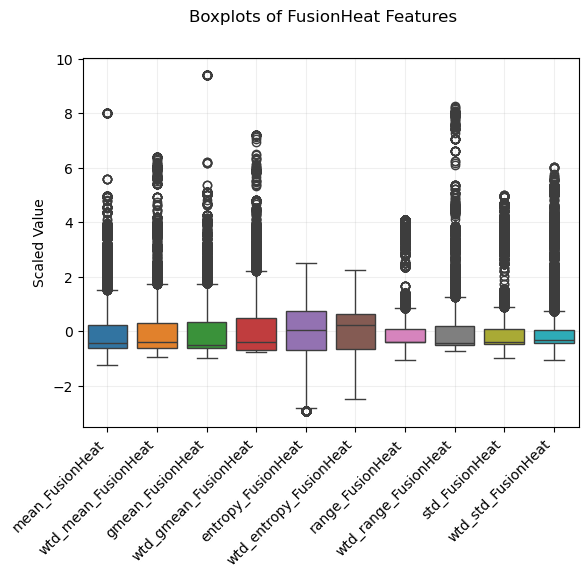

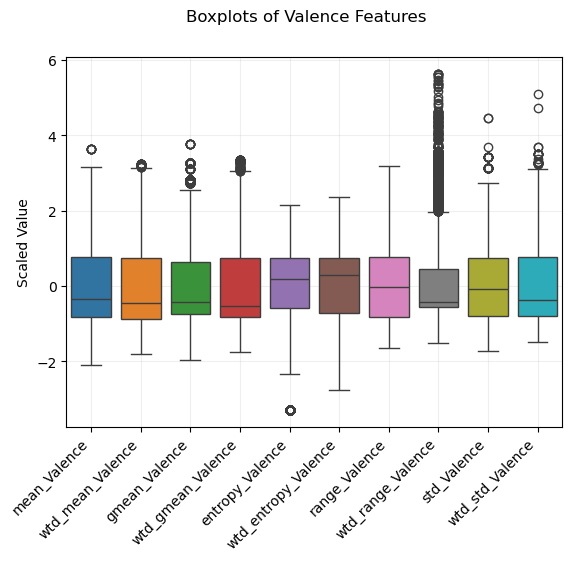

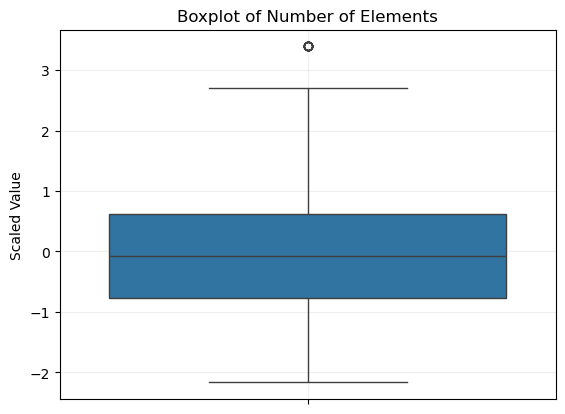

In [25]:

# Create box plot for FusionHeat
sns.boxplot(data=X_scaled.iloc[:,51:61])
plt.suptitle('Boxplots of FusionHeat Features')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Scaled Value')
plt.grid(True, alpha=0.2)
plt.show()

# Create box plot for Valence
sns.boxplot(data=X_scaled.iloc[:,71:81])
plt.suptitle('Boxplots of Valence Features')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Scaled Value')
plt.grid(True, alpha=0.2)
plt.show()

# Create box plot for number of elements
sns.boxplot(data=X_scaled.iloc[:,0])
plt.title('Boxplot of Number of Elements')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Scaled Value')
plt.grid(True, alpha=0.2)
plt.show()

### Instantiate the Models and Tune Hyperparameters

In [26]:
# Instantiate the model classes
lr_model = LinearRegression()
l1_model = Lasso(max_iter=10000) # smaller alphas wouldn't converge with default max_iters=1000
l2_model = Ridge()
en_model = ElasticNet(max_iter=30000)

In [27]:
# Instantiate a KFold class object to randomly shuffle the dataset in cv folds
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

# Tune alpha (or Alpha and L1_ratio for ElasticNet)

# for Lasso: default alpha = 1, ordinary least squares = 0
print('Tuning Lasso:')
l1_results = []
l1_alphas = [10, 5, 2, 1] + list(np.round(np.arange(0.9, 0, -0.1), 2)) + [0.05]
for l1_alpha in l1_alphas:
    l1_model.alpha=l1_alpha
    l1_mse = -np.mean(cross_val_score(l1_model, X_scaled, y, cv=cv, scoring='neg_mean_squared_error'))
    l1_results.append((l1_alpha, l1_mse))
    print(f'Alpha: {l1_alpha}, CV MSE: {l1_mse:.4f}')

print('-----------')

# for Ridge: default alpha = 1, ordinary least squares = 0
print('Tuning Ridge:')
l2_results = []
l2_alpha = 1E-5
for i in range(10):
    l2_model.alpha=l2_alpha
    l2_mse = -np.mean(cross_val_score(l2_model, X_scaled, y, cv=cv, scoring='neg_mean_squared_error'))
    l2_results.append((l2_alpha, l2_mse))
    print(f'Alpha: {l2_alpha}, CV MSE: {l2_mse:.4f}')
    l2_alpha = l2_alpha * 10   

print('-----------')

# for ElasticNet
# use GridSearchCV rather than write a nested loop to search the penalty term and mixing parameter
print('Tuning ElasticNet:')
# Define the parameter grid
param_grid = {'alpha': np.logspace(-3, 3, num=7), 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
# Setup the GridsearchCV object
en_grid = GridSearchCV(en_model, param_grid, cv=cv, scoring='neg_mean_squared_error', verbose=True, n_jobs=-1)
# Fit the model
en_grid.fit(X_scaled, y)
# Print the best parameters and the best score
print(f"Best Alpha: {en_grid.best_params_['alpha']} and Best L1 Ratio: {en_grid.best_params_['l1_ratio']}")
print(f"Best CV MSE: {-en_grid.best_score_:.4f}")

Tuning Lasso:
Alpha: 10, CV MSE: 665.2587
Alpha: 5, CV MSE: 504.8166
Alpha: 2, CV MSE: 405.0858
Alpha: 1, CV MSE: 367.1102
Alpha: 0.9, CV MSE: 363.2334
Alpha: 0.8, CV MSE: 358.0250
Alpha: 0.7, CV MSE: 351.9319
Alpha: 0.6, CV MSE: 346.3483
Alpha: 0.5, CV MSE: 340.9802
Alpha: 0.4, CV MSE: 334.9228
Alpha: 0.3, CV MSE: 333.5129
Alpha: 0.2, CV MSE: 349.0375
Alpha: 0.1, CV MSE: 380.3097
Alpha: 0.05, CV MSE: 427.1472
-----------
Tuning Ridge:
Alpha: 1e-05, CV MSE: 687.5473
Alpha: 0.0001, CV MSE: 687.5435
Alpha: 0.001, CV MSE: 687.5057
Alpha: 0.01, CV MSE: 687.1311
Alpha: 0.1, CV MSE: 683.6407
Alpha: 1.0, CV MSE: 661.8533
Alpha: 10.0, CV MSE: 594.4701
Alpha: 100.0, CV MSE: 439.4202
Alpha: 1000.0, CV MSE: 334.2301
Alpha: 10000.0, CV MSE: 373.9129
-----------
Tuning ElasticNet:
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Best Alpha: 0.1 and Best L1 Ratio: 0.1
Best CV MSE: 332.2655


In [28]:
# Print all the results for Elastic Net
for a, l1, mse in zip(en_grid.cv_results_['param_alpha'],
                      en_grid.cv_results_['param_l1_ratio'],
                      -en_grid.cv_results_['mean_test_score']):
    print(f"Alpha: {a}, L1 Ratio: {l1}, MSE: {mse:.4f}")

Alpha: 0.001, L1 Ratio: 0.1, MSE: 571.3237
Alpha: 0.001, L1 Ratio: 0.3, MSE: 584.0029
Alpha: 0.001, L1 Ratio: 0.5, MSE: 599.0046
Alpha: 0.001, L1 Ratio: 0.7, MSE: 617.7215
Alpha: 0.001, L1 Ratio: 0.9, MSE: 645.9908
Alpha: 0.01, L1 Ratio: 0.1, MSE: 409.5117
Alpha: 0.01, L1 Ratio: 0.3, MSE: 423.8869
Alpha: 0.01, L1 Ratio: 0.5, MSE: 444.2700
Alpha: 0.01, L1 Ratio: 0.7, MSE: 474.3123
Alpha: 0.01, L1 Ratio: 0.9, MSE: 525.4772
Alpha: 0.1, L1 Ratio: 0.1, MSE: 332.2655
Alpha: 0.1, L1 Ratio: 0.3, MSE: 332.7617
Alpha: 0.1, L1 Ratio: 0.5, MSE: 334.7113
Alpha: 0.1, L1 Ratio: 0.7, MSE: 340.3870
Alpha: 0.1, L1 Ratio: 0.9, MSE: 357.1750
Alpha: 1.0, L1 Ratio: 0.1, MSE: 395.9824
Alpha: 1.0, L1 Ratio: 0.3, MSE: 394.3585
Alpha: 1.0, L1 Ratio: 0.5, MSE: 391.1244
Alpha: 1.0, L1 Ratio: 0.7, MSE: 385.0079
Alpha: 1.0, L1 Ratio: 0.9, MSE: 373.5304
Alpha: 10.0, L1 Ratio: 0.1, MSE: 545.8735
Alpha: 10.0, L1 Ratio: 0.3, MSE: 570.6373
Alpha: 10.0, L1 Ratio: 0.5, MSE: 599.4462
Alpha: 10.0, L1 Ratio: 0.7, MSE: 627.97

In [29]:
# Get an intuition for the coefficients

print('Lasso:')
l1_alphas = [0.4, 0.3, 0.2]
for l1_alpha in l1_alphas:
    l1_model.alpha=l1_alpha
    l1_model.fit(X_scaled, y)
    # Count non-zero coefficients
    l1_nonzero_count = np.sum(l1_model.coef_ != 0)
    print(f'Alpha: {l1_alpha}, Non-Zero Count: {l1_nonzero_count}')

print('-----------')

print('Ridge:')
l2_alphas = [100, 1000, 10000]
for l2_alpha in l2_alphas:
    l2_model.alpha=l2_alpha
    l2_model.fit(X_scaled, y)
    # Count non-zero coefficients
    l2_nonzero_count = np.sum(l2_model.coef_ != 0) # I don't expect this to change
    print(f'Alpha: {l2_alpha}, Non-Zero Count: {l2_nonzero_count}')

Lasso:
Alpha: 0.4, Non-Zero Count: 37
Alpha: 0.3, Non-Zero Count: 44
Alpha: 0.2, Non-Zero Count: 59
-----------
Ridge:
Alpha: 100, Non-Zero Count: 158
Alpha: 1000, Non-Zero Count: 158
Alpha: 10000, Non-Zero Count: 158


In [30]:
# Fine-tune parameters

print('Tuning Lasso:')
l1_alphas = list(np.round(np.arange(0.22, 0.40, 0.02), 2))
for l1_alpha in l1_alphas:
    l1_model.alpha=l1_alpha
    l1_mse = -np.mean(cross_val_score(l1_model, X_scaled, y, cv=cv, scoring='neg_mean_squared_error'))
    l1_results.append((l1_alpha, l1_mse))
    print(f'Alpha: {l1_alpha}, CV MSE: {l1_mse:.4f}')

print('-----------')

# for Ridge: default alpha = 1, ordinary least squares = 0
print('Tuning Ridge:')
l2_alphas = [100, 200] + list(range(500, 1000, 100)) + list(range(1000, 10000, 1000))
for l2_alpha in l2_alphas:
    l2_model.alpha=l2_alpha
    l2_mse = -np.mean(cross_val_score(l2_model, X_scaled, y, cv=cv, scoring='neg_mean_squared_error'))
    l2_results.append((l2_alpha, l2_mse))
    print(f'Alpha: {l2_alpha}, CV MSE: {l2_mse:.4f}')

print('-----------')

# for ElasticNet
# use GridSearchCV rather than write a nested loop to search the penalty term and mixing parameter
print('Tuning ElasticNet:')
# Define the parameter grid
param_grid_narrow = {'alpha': [en_grid.best_params_['alpha']] + list(np.linspace(0.5, 0.02, 5)),
                     'l1_ratio': [en_grid.best_params_['l1_ratio']] + list(np.arange(0.09, -0.01, -0.02))}
# Setup the GridsearchCV object
en_grid_narrow = GridSearchCV(en_model, param_grid_narrow, cv=cv, scoring='neg_mean_squared_error', verbose=True, n_jobs=-1)
# Fit the model
en_grid_narrow.fit(X_scaled, y)
# Print the best parameters and the best score
print(f"Best Alpha: {en_grid_narrow.best_params_['alpha']} and Best L1 Ratio: {en_grid_narrow.best_params_['l1_ratio']}")
print(f"Best CV MSE: {-en_grid_narrow.best_score_:.4f}")

Tuning Lasso:
Alpha: 0.22, CV MSE: 344.5755
Alpha: 0.24, CV MSE: 340.8585
Alpha: 0.26, CV MSE: 337.6774
Alpha: 0.28, CV MSE: 335.2876
Alpha: 0.3, CV MSE: 333.5129
Alpha: 0.32, CV MSE: 332.3397
Alpha: 0.34, CV MSE: 332.0307
Alpha: 0.36, CV MSE: 332.6371
Alpha: 0.38, CV MSE: 333.7822
-----------
Tuning Ridge:
Alpha: 100, CV MSE: 439.4202
Alpha: 200, CV MSE: 393.5862
Alpha: 500, CV MSE: 349.8227
Alpha: 600, CV MSE: 344.1914
Alpha: 700, CV MSE: 340.2908
Alpha: 800, CV MSE: 337.5440
Alpha: 900, CV MSE: 335.5991
Alpha: 1000, CV MSE: 334.2301
Alpha: 2000, CV MSE: 333.2799
Alpha: 3000, CV MSE: 338.5080
Alpha: 4000, CV MSE: 344.4885
Alpha: 5000, CV MSE: 350.3077
Alpha: 6000, CV MSE: 355.7623
Alpha: 7000, CV MSE: 360.8232
Alpha: 8000, CV MSE: 365.5118
Alpha: 9000, CV MSE: 369.8629
-----------
Tuning ElasticNet:
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Alpha: 0.1 and Best L1 Ratio: 0.09
Best CV MSE: 332.2648


In [31]:
# Print all the results for Elastic Net
for a, l1, mse in zip(en_grid_narrow.cv_results_['param_alpha'],
                      en_grid_narrow.cv_results_['param_l1_ratio'],
                      -en_grid_narrow.cv_results_['mean_test_score']):
    print(f"Alpha: {a}, L1 Ratio: {l1:.3f}, MSE: {mse:.4f}")

Alpha: 0.1, L1 Ratio: 0.100, MSE: 332.2655
Alpha: 0.1, L1 Ratio: 0.090, MSE: 332.2648
Alpha: 0.1, L1 Ratio: 0.070, MSE: 332.2657
Alpha: 0.1, L1 Ratio: 0.050, MSE: 332.2750
Alpha: 0.1, L1 Ratio: 0.030, MSE: 332.2902
Alpha: 0.1, L1 Ratio: 0.010, MSE: 332.3114
Alpha: 0.5, L1 Ratio: 0.100, MSE: 366.5257
Alpha: 0.5, L1 Ratio: 0.090, MSE: 366.6520
Alpha: 0.5, L1 Ratio: 0.070, MSE: 366.9048
Alpha: 0.5, L1 Ratio: 0.050, MSE: 367.1535
Alpha: 0.5, L1 Ratio: 0.030, MSE: 367.3935
Alpha: 0.5, L1 Ratio: 0.010, MSE: 367.6312
Alpha: 0.38, L1 Ratio: 0.100, MSE: 356.7701
Alpha: 0.38, L1 Ratio: 0.090, MSE: 356.9135
Alpha: 0.38, L1 Ratio: 0.070, MSE: 357.1961
Alpha: 0.38, L1 Ratio: 0.050, MSE: 357.4751
Alpha: 0.38, L1 Ratio: 0.030, MSE: 357.7473
Alpha: 0.38, L1 Ratio: 0.010, MSE: 358.0213
Alpha: 0.26, L1 Ratio: 0.100, MSE: 345.7079
Alpha: 0.26, L1 Ratio: 0.090, MSE: 345.8357
Alpha: 0.26, L1 Ratio: 0.070, MSE: 346.0934
Alpha: 0.26, L1 Ratio: 0.050, MSE: 346.3482
Alpha: 0.26, L1 Ratio: 0.030, MSE: 346.6044


### Plot Tuning Curves for Alpha

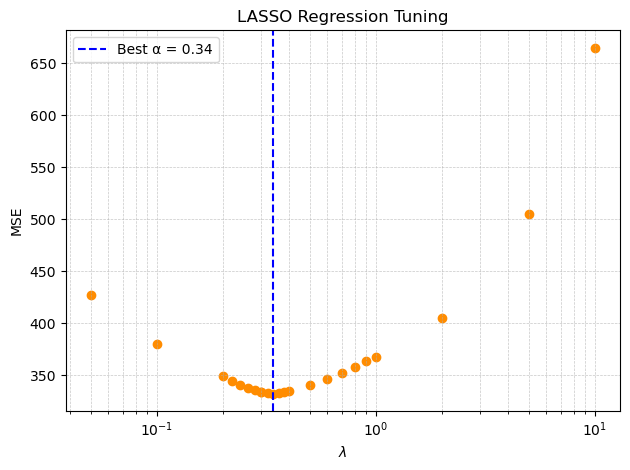

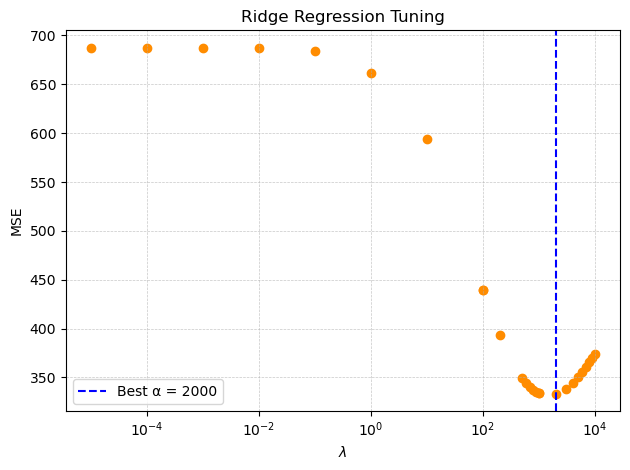

In [32]:
# Sort results by alpha before plotting

# L1 results
l1_results_sorted = sorted(l1_results, key=lambda x: x[0])
l1_alphas, l1_mses = zip(*l1_results_sorted) # unpacks the (alpha, mse) into a tuple of alphas and a tuple of mses
l1_best_idx = l1_mses.index(min(l1_mses))
l1_best_alpha = l1_alphas[l1_best_idx]

# L2 results
l2_results_sorted = sorted(l2_results, key=lambda x: x[0])
l2_alphas, l2_mses = zip(*l2_results_sorted)
l2_best_idx = l2_mses.index(min(l2_mses))
l2_best_alpha = l2_alphas[l2_best_idx]

# L1 plot
plt.figure()
plt.scatter(l1_alphas, l1_mses, color='darkorange')
plt.axvline(x=l1_best_alpha, color='blue', linestyle='--', label=f'Best α = {l1_best_alpha}')
plt.xscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel('MSE')
plt.title('LASSO Regression Tuning')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

# L2 plot
plt.figure()
plt.scatter(l2_alphas, l2_mses, color='darkorange')
plt.axvline(x=l2_best_alpha, color='blue', linestyle='--', label=f'Best α = {l2_best_alpha}')
plt.xscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel('MSE')
plt.title('Ridge Regression Tuning')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


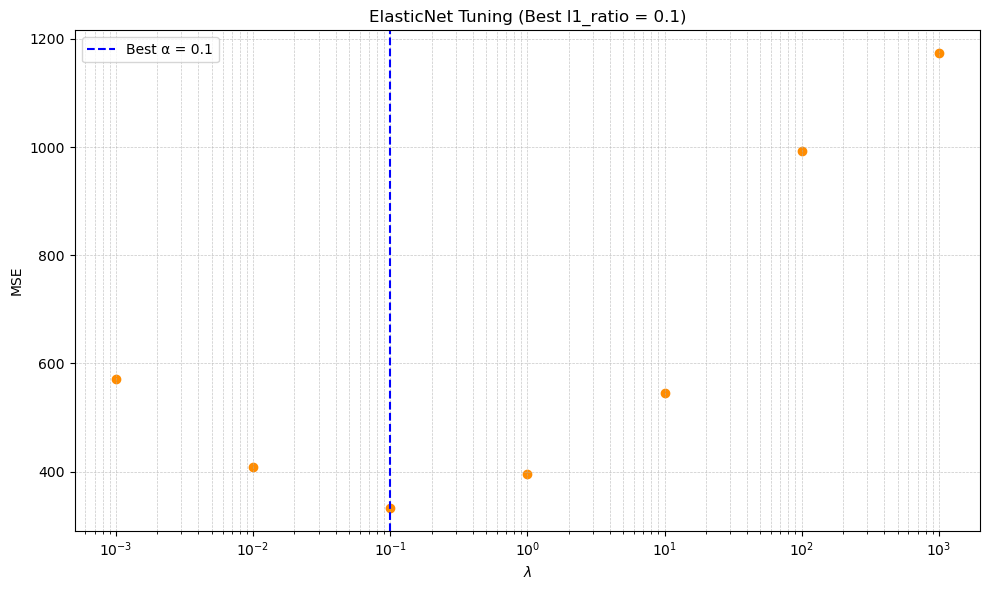

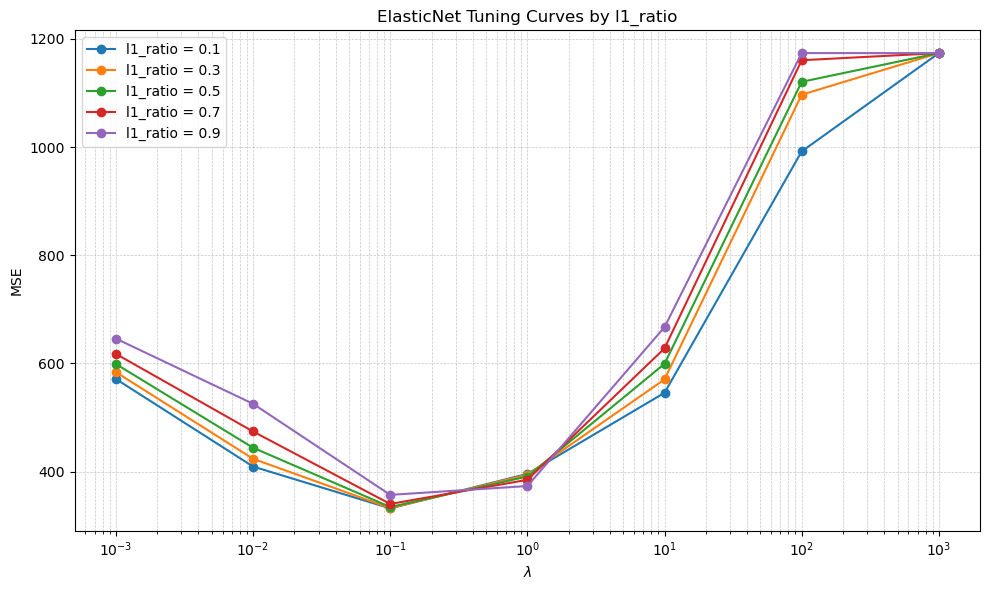

In [33]:
# Convert cv_results_ to a DataFrame
en_results_df = pd.DataFrame(en_grid.cv_results_)

# Get the best l1_ratio
best_l1_ratio = en_grid.best_params_['l1_ratio']

# Filter the results to just that l1_ratio
subset = en_results_df[en_results_df['param_l1_ratio'] == best_l1_ratio]

# Extract alpha values and corresponding MSEs
alphas = subset['param_alpha'].astype(float)
mses = -subset['mean_test_score']

# Find the best alpha for this l1_ratio
best_idx = mses.idxmin()
best_alpha = alphas.loc[best_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(alphas, mses, color='darkorange')
plt.axvline(x=best_alpha, color='blue', linestyle='--', label=f'Best α = {best_alpha}')
plt.xscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel('MSE')
plt.title(f'ElasticNet Tuning (Best l1_ratio = {best_l1_ratio})')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


# See all curves on one plot
plt.figure(figsize=(10, 6))

for ratio in sorted(en_results_df['param_l1_ratio'].unique()):
    subset = en_results_df[en_results_df['param_l1_ratio'] == ratio]
    alphas = subset['param_alpha'].astype(float)
    mses = -subset['mean_test_score']
    plt.plot(alphas, mses, marker='o', label=f'l1_ratio = {ratio}')

plt.xscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel('MSE')
plt.title('ElasticNet Tuning Curves by l1_ratio')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


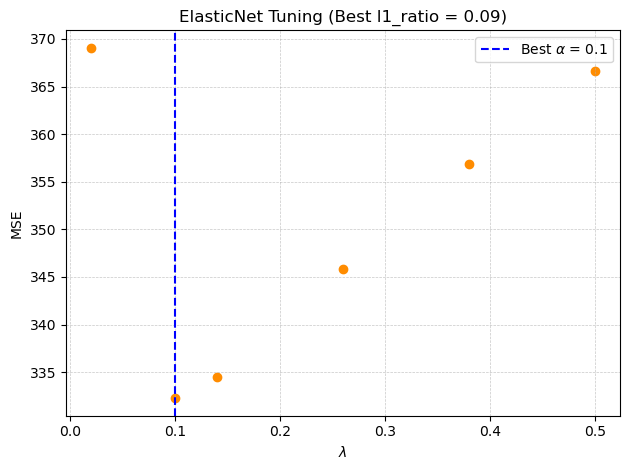

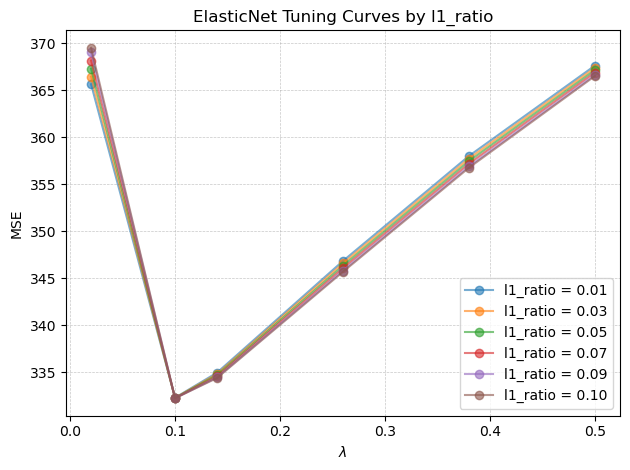

In [34]:
# Repeat for the narrow grid search
# Convert cv_results_ to a DataFrame
en_results_narrow_df = pd.DataFrame(en_grid_narrow.cv_results_)
# en_results_narrow_df = pd.concat([en_results_narrow_df, en_results_df], ignore_index=True)
en_results_narrow_df = en_results_narrow_df.sort_values(by='param_alpha')

# Get the best l1_ratio
best_l1_ratio = en_grid_narrow.best_params_['l1_ratio']

# Filter the results to just that l1_ratio
subset = en_results_narrow_df[np.isclose(en_results_narrow_df['param_l1_ratio'], best_l1_ratio)]

# Extract alpha values and corresponding MSEs
alphas = subset['param_alpha'].astype(float)
mses = -subset['mean_test_score']

# Find the best alpha for this l1_ratio
best_idx = mses.idxmin()
best_alpha = alphas.loc[best_idx]

# Plot
plt.figure()
plt.scatter(alphas, mses, color='darkorange')
plt.axvline(x=best_alpha, color='blue', linestyle='--', label=f'Best $\\alpha$ = {best_alpha}')
# plt.xscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel('MSE')
plt.title(f'ElasticNet Tuning (Best l1_ratio = {best_l1_ratio})')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


# See all curves on one plot
plt.figure()

for ratio in sorted(en_results_narrow_df['param_l1_ratio'].unique()):
    subset = en_results_narrow_df[np.isclose(en_results_narrow_df['param_l1_ratio'], ratio)]
    alphas = subset['param_alpha'].astype(float)
    mses = -subset['mean_test_score']
    plt.plot(alphas, mses, marker='o', label=f'l1_ratio = {ratio:.2f}', alpha=0.6)

# plt.xscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel('MSE')
plt.title('ElasticNet Tuning Curves by l1_ratio')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


### Fit the Models to All (Training) Data and Get CV MSEs for Each Model

In [35]:
# Set the best alpha and if applicable l1_ratio
l1_best_alpha = 0.34
l1_model.alpha = l1_best_alpha
l2_best_alpha = 2000
l2_model.alpha = l2_best_alpha
en_best_alpha = en_grid_narrow.best_params_['alpha']
en_best_l1ratio = en_grid_narrow.best_params_['l1_ratio']
en_model.alpha = en_best_alpha
en_model.l1_ratio = en_best_l1ratio

# Compare the MSEs and standard deviations

lr_scores = cross_val_score(lr_model, X_scaled, y, cv=cv, scoring='neg_mean_squared_error')
lr_mse = -np.mean(lr_scores)  # Negate because scores are negative
lr_sd = np.std(lr_scores)
lr_rmse = np.sqrt(lr_mse)

l1_scores = cross_val_score(l1_model, X_scaled, y, cv=cv, scoring='neg_mean_squared_error')
l1_mse = -np.mean(l1_scores)
l1_sd = np.std(l1_scores)
l1_rmse = np.sqrt(l1_mse)

l2_scores = cross_val_score(l2_model, X_scaled, y, cv=cv, scoring='neg_mean_squared_error')
l2_mse = -np.mean(l2_scores)
l2_sd = np.std(l2_scores)
l2_rmse = np.sqrt(l2_mse)

en_scores = cross_val_score(en_model, X_scaled, y, cv=cv, scoring='neg_mean_squared_error')
en_mse = -np.mean(en_scores)
en_sd = np.std(en_scores)
en_rmse = np.sqrt(l1_mse)

print(f'CV MSE of linear regression (OLS) model: {lr_mse:.3f} ± {lr_sd:.3f}')
print(f'CV MSE of lasso model: {l1_mse:.3f} ± {l1_sd:.3f} with alpha = {l1_best_alpha}')
print(f'CV MSE of ridge model: {l2_mse:.3f} ± {l2_sd:.3f} with alpha = {l2_best_alpha}')
print(f'CV MSE of elasticnet model: {en_mse:.3f} ± {en_sd:.3f} with alpha = {en_best_alpha} and l1_ratio = {en_best_l1ratio}')
print(f'CV RMSEs of each model are: LR - {lr_rmse:.3f}, L1 - {l1_rmse:.3f}, L2 - {l2_rmse:.3f}, EN - {en_rmse:.3f}')

CV MSE of linear regression (OLS) model: 687.548 ± 584.201
CV MSE of lasso model: 332.031 ± 15.995 with alpha = 0.34
CV MSE of ridge model: 333.280 ± 25.456 with alpha = 2000
CV MSE of elasticnet model: 332.265 ± 30.309 with alpha = 0.1 and l1_ratio = 0.09
CV RMSEs of each model are: LR - 26.221, L1 - 18.222, L2 - 18.256, EN - 18.222


### Calculate and Plot the Residuals

In [36]:
# Use cross_val_predict to get out of fold residuals

# Get cross-validated predictions and calculate the residuals

lr_pred = cross_val_predict(lr_model, X_scaled, y, cv=cv)
lr_residuals = y - lr_pred

l1_pred = cross_val_predict(l1_model, X_scaled, y, cv=cv)
l1_residuals = y - l1_pred

l2_pred = cross_val_predict(l2_model, X_scaled, y, cv=cv)
l2_residuals = y - l2_pred

en_pred = cross_val_predict(lr_model, X_scaled, y, cv=cv)
en_residuals = y - en_pred


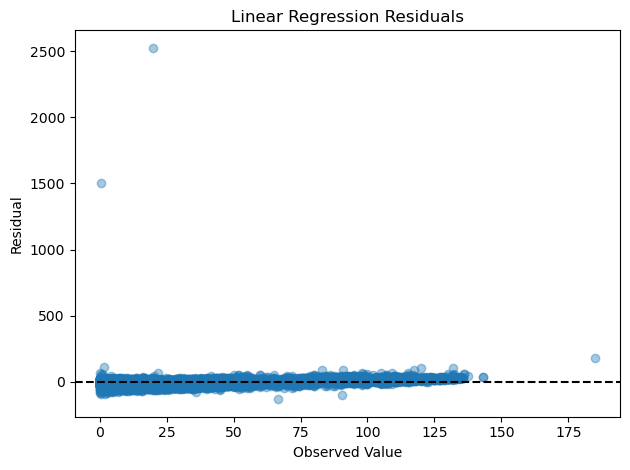

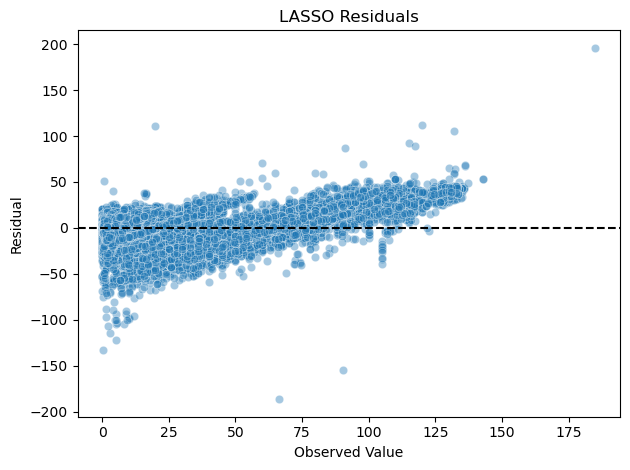

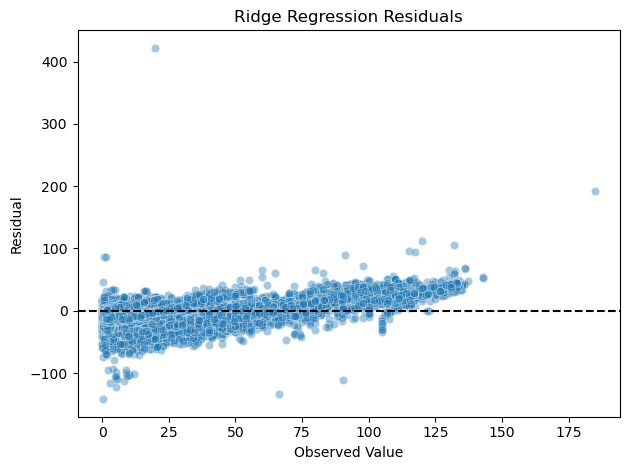

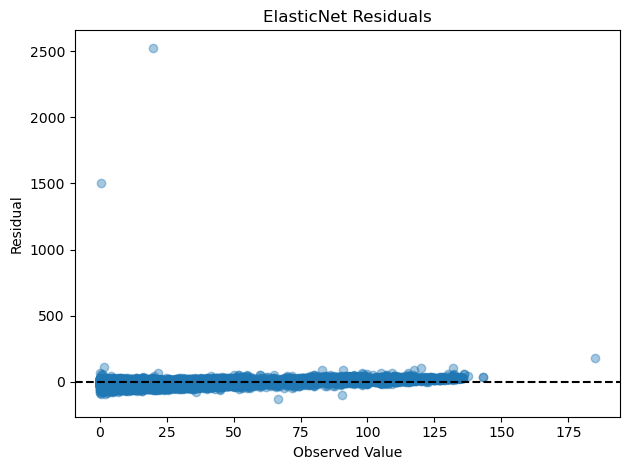

In [37]:
# Plot: residuals vs actual target

# LR model
plt.figure()
plt.scatter(y, lr_residuals, alpha=0.4)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Observed Value')
plt.ylabel('Residual')
plt.title('Linear Regression Residuals')
plt.tight_layout()
plt.show()

# L1 model
plt.figure()
sns.scatterplot(x=y, y=l1_residuals, alpha=0.4)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Observed Value')
plt.ylabel('Residual')
plt.title('LASSO Residuals')
plt.tight_layout()
plt.show()

# L2 model
plt.figure()
sns.scatterplot(x=y, y=l2_residuals, alpha=0.4)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Observed Value')
plt.ylabel('Residual')
plt.title('Ridge Regression Residuals')
plt.tight_layout()
plt.show()

# ElasticNet model
plt.figure()
plt.scatter(y, en_residuals, alpha=0.4)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Observed Value')
plt.ylabel('Residual')
plt.title('ElasticNet Residuals')
plt.tight_layout()
plt.show()


### Get the Most Important Features

In [38]:
# Refit the models to get the coefficients
print('Top 15 Most Important Variables')
print('----------')

# Get feature names
feature_names = X_scaled.columns

print('Lasso coefficients:')
# Fit with best alpha
l1_model.set_params(alpha=l1_best_alpha).fit(X_scaled, y)
# Get the coefficients
l1_coefs = l1_model.coef_
# Combine names and coefs in a list of tuples
l1_coef_table = list(zip(feature_names, l1_coefs))
# Sort in descending order by absolute value of the coefficient and store the top 10
l1_top_10 = sorted(l1_coef_table, key=lambda x: abs(x[1]), reverse=True)[:15]
# Print them
for name, val in l1_top_10:
    print(f'{name}: {val:.4f}')

print('----------')

print('Ridge coefficients:')
l2_model.set_params(alpha=l2_best_alpha).fit(X_scaled, y)
l2_coefs = l2_model.coef_
l2_coef_table = list(zip(feature_names, l2_coefs))
l2_top_10 = sorted(l2_coef_table, key=lambda x: abs(x[1]), reverse=True)[:15]
for name, val in l2_top_10:
    print(f'{name}: {val:.4f}')

Top 15 Most Important Variables
----------
Lasso coefficients:
Ba: 9.6611
wtd_mean_ThermalConductivity: 9.3633
wtd_gmean_ThermalConductivity: -7.8230
range_atomic_mass: 5.6861
Bi: 4.7018
wtd_std_Valence: -4.1390
wtd_std_ThermalConductivity: 3.5222
wtd_gmean_ElectronAffinity: -3.4903
Ca: 3.4441
wtd_entropy_ElectronAffinity: -3.0947
wtd_entropy_atomic_mass: 3.0875
wtd_entropy_ThermalConductivity: 3.0718
wtd_std_atomic_mass: -2.6328
gmean_Density: -2.0524
range_atomic_radius: 1.8566
----------
Ridge coefficients:
Ba: 7.9984
wtd_mean_ThermalConductivity: 4.6383
wtd_std_Valence: -4.5681
wtd_std_ThermalConductivity: 4.0882
Bi: 3.9989
wtd_gmean_ThermalConductivity: -3.6752
range_atomic_mass: 3.6284
wtd_entropy_ElectronAffinity: -3.3169
Ca: 3.2274
wtd_gmean_ElectronAffinity: -2.9756
wtd_std_atomic_mass: -2.8916
wtd_entropy_atomic_mass: 2.7135
range_atomic_radius: 2.3408
gmean_ThermalConductivity: -1.9918
wtd_entropy_FusionHeat: 1.9578
